
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 15
             Gate count: 21
    Nonlocal gate count: 8
         Gate breakdown: RZ: 10, CX: 8, RY: 2, RX: 1


SparsePauliOp(['IZZ', 'ZZI', 'IIZ', 'IZI', 'ZII', 'IIX', 'IXI', 'XII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j,
 -0.38268343+0.j, -0.92387953+0.j, -0.92387953+0.j, -0.92387953+0.j])


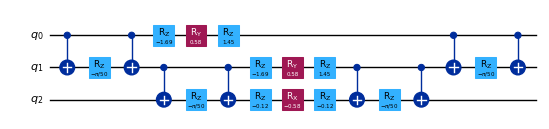

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.converters import circuit_to_dag

from gate_estimation.cutter_search_manual import *

def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

second_order_formula = SuzukiTrotter()

L = 3
H = get_hamiltonian(L=L, J=0.2, h=1.0, alpha=np.pi / 8)
final_time = np.pi
num_timesteps = 10
dt = final_time / num_timesteps
initial_state = Statevector.from_label("000")

trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
for i in range(1):
    circuit.append(trotter_step_second_order, range(H.num_qubits))
# circuit = circuit.decompose(reps=1)
target_basis = ['rx', 'ry', 'rz', 'h', 'cx']
circuit = transpile(circuit,
                       basis_gates=target_basis, 
                       optimization_level=1) 

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)
print(H)

circuit.draw("mpl", scale=0.5)

In [2]:
n_vertices, gate_edges, wire_edges, node_name_ids, id_node_names = read_circ(circuit)
G = nx.Graph() 
G.add_edges_from([(a, b) for idx, a in enumerate(gate_edges+wire_edges) for b in gate_edges+wire_edges[idx + 1:]])


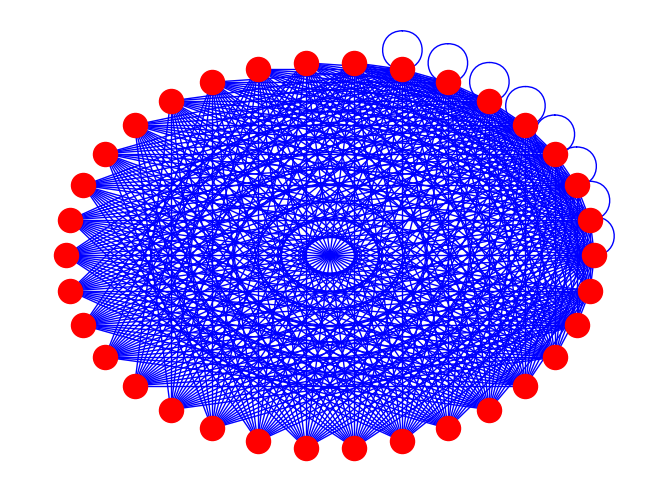

In [3]:
nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')

In [8]:
cut_weight, partitions = nx.minimum_cut(G, "s", "t")
print("cut edges capacity " + str(cut_weight))
print("Set of nodes in the 's' partition: " + str(partitions[0]))
print("Set of nodes in the 't' partition: " + str(partitions[1]))
edge_cut_list = [] # Computed by listing edges between the 2 partitions
for p1_node in partitions[0]:
    for p2_node in partitions[1]:
        if G.has_edge(p1_node,p2_node):
            edge_cut_list.append((p1_node,p2_node))
print("Edges of the cut: " + str(edge_cut_list))

NetworkXError: node s not in graph

In [ ]:
cut = True
while cut:
    c, (temp1, temp2) = nx.approximation.randomized_partitioning(G, p=1/3)
    if c < 10 and c > 0:
        cut = False
print(temp1)
print(temp2)
print(c)

In [14]:
cut_size, partition = nx.approximation.randomized_partitioning(G, p=1/2)
subpartition = [list(p) for p in partition]
cuts = [cut_size]
num_partition = 4
for i in range(int(np.log2(num_partition))-1):
      sub = []
      for j in subpartition:
                  temp = nx.Graph()
                  temp.add_edges_from(j)
                  s, (p1, p2) = nx.approximation.randomized_partitioning(G, p=1/2)
                  cuts.append(s)
                  sub.append(list(p1))
                  sub.append(list(p2))
      subpartition = sub
for i in subpartition:
      print(i)
print(cuts)

[(13, 14), (3, 8), (11, 16), (22, 24), (26, 27), (19, 20), (11, 12), (2, 3), (0, 2), (8, 9), (5, 6), (19, 22), (14, 15), (16, 17)]
[(24, 27), (3, 4), (21, 22), (22, 23), (17, 18), (19, 21), (27, 28), (24, 26), (18, 19), (8, 11), (0, 1), (10, 11), (11, 13), (24, 25), (6, 7), (15, 19), (7, 24), (3, 5), (0, 3), (8, 10)]
[(13, 14), (10, 11), (22, 24), (26, 27), (19, 20), (21, 22), (18, 19), (0, 2), (19, 22), (14, 15), (16, 17)]
[(24, 27), (3, 4), (22, 23), (8, 9), (17, 18), (19, 21), (27, 28), (24, 26), (5, 6), (8, 11), (0, 1), (11, 16), (11, 13), (24, 25), (6, 7), (15, 19), (7, 24), (3, 5), (3, 8), (0, 3), (8, 10), (11, 12), (2, 3)]
[195, 188, 176]


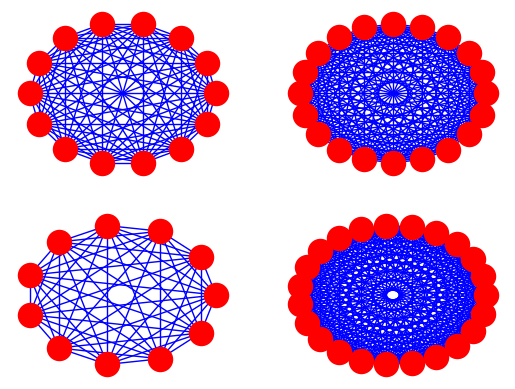

In [15]:
G1 = nx.Graph() 
G2 = nx.Graph()
G3 = nx.Graph() 
G4 = nx.Graph()
G1.add_edges_from([(a, b) for idx, a in enumerate(subpartition[0]) for b in subpartition[0][idx + 1:]])
G2.add_edges_from([(a, b) for idx, a in enumerate(subpartition[1]) for b in subpartition[1][idx + 1:]])
G3.add_edges_from([(a, b) for idx, a in enumerate(subpartition[2]) for b in subpartition[2][idx + 1:]])
G4.add_edges_from([(a, b) for idx, a in enumerate(subpartition[3]) for b in subpartition[3][idx + 1:]])
subax1 = plt.subplot(221)
nx.draw(G1, pos=nx.circular_layout(G1), node_color='r', edge_color='b')   # default spring_layout
subax2 = plt.subplot(222)
nx.draw(G2, pos=nx.circular_layout(G2), node_color='r', edge_color='b')
subax3 = plt.subplot(223)
nx.draw(G3, pos=nx.circular_layout(G3), node_color='r', edge_color='b')   # default spring_layout
subax4 = plt.subplot(224)
nx.draw(G4, pos=nx.circular_layout(G4), node_color='r', edge_color='b')

In [ ]:
dag = circuit_to_dag(circuit)
gate_edges = []
wire_edges = []
node_name_ids = {}
id_node_names = {}
vertex_ids = {}
curr_node_id = 0
total_node_id = 0
qubit_gate_counter = {}
gate_set = {"rx", "ry", "rz", "t"}
for qubit in dag.qubits:
    qubit_gate_counter[qubit] = 0
for vertex in dag.topological_op_nodes():
    
    if len(vertex.qargs) == 2:
        arg0, arg1 = vertex.qargs

        vertex_name = "%s[%d]%d" % (
            arg0._register.name,
            arg0._index,
            qubit_gate_counter[arg0],
        )
        qubit_gate_counter[arg0] += 1

        if vertex_name not in node_name_ids and id(vertex) not in vertex_ids:
            node_name_ids[vertex_name] = [curr_node_id,'cnot0']
            id_node_names[curr_node_id] = vertex_name
            vertex_ids[id(vertex)] = curr_node_id
            gate_edges.append((curr_node_id,curr_node_id+1))
            curr_node_id += 1

            vertex_name = "%s[%d]%d" % (
                arg1._register.name,
                arg1._index,
                qubit_gate_counter[arg1],
            )
            qubit_gate_counter[arg1] += 1

            if vertex_name not in node_name_ids:
                node_name_ids[vertex_name] = [curr_node_id,'cnot1']
                id_node_names[curr_node_id] = vertex_name
                # vertex_ids[id(vertex)] = curr_node_id
                curr_node_id += 1
            total_node_id += 1

    elif len(vertex.qargs) == 1:
        arg = vertex.qargs[0]

        vertex_name = "%s[%d]%d" % (
            arg._register.name,
            arg._index,
            qubit_gate_counter[arg],
        )
        qubit_gate_counter[arg] += 1
        if vertex_name not in node_name_ids and id(vertex) not in vertex_ids:
            if dag.op_nodes()[total_node_id].op.name in gate_set: 
                node_name_ids[vertex_name] = [curr_node_id,dag.op_nodes()[total_node_id].op.name]
                id_node_names[curr_node_id] = vertex_name
                vertex_ids[id(vertex)] = curr_node_id
                curr_node_id += 1
                total_node_id += 1

    else:
        raise Exception("vertex does not have 1 or 2 qargs!")
    # print(node_name_ids)
for u, v, _ in dag.edges():
    if isinstance(u, DAGOpNode) and isinstance(v, DAGOpNode):
        u_id = vertex_ids[id(u)]
        v_id = vertex_ids[id(v)]
        wire_edges.append((u_id, v_id))
        # print(edges)

n_vertices = sum([len(node.split(' ')) for node in list(id_node_names.values())])

In [23]:
for d in circuit_to_dag(circuit).nodes():
    print(d.args)

AttributeError: 'DAGInNode' object has no attribute 'args'